metric_name:  requests_start_count;  dp:  0
res items:  1062
Series([], dtype: float64)
metric_name:  requests_start_count;  dp:  0
res items:  1059
Series([], dtype: float64)
metric_name:  requests_start_count;  dp:  0
res items:  1055
Series([], dtype: float64)
metric_name:  requests_start_count;  dp:  0
res items:  1051
Series([], dtype: float64)
3.82 sec


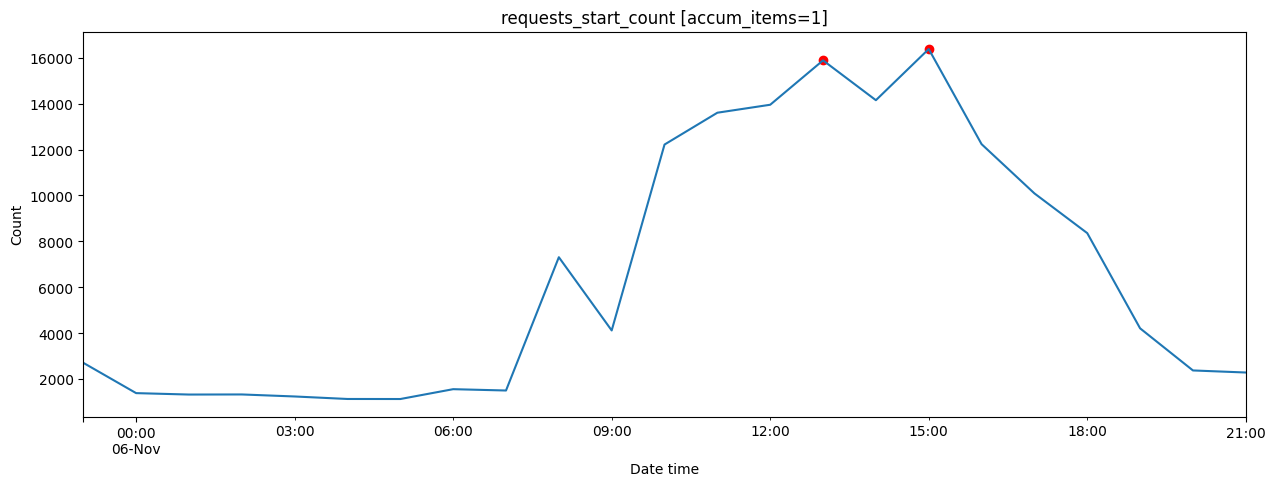

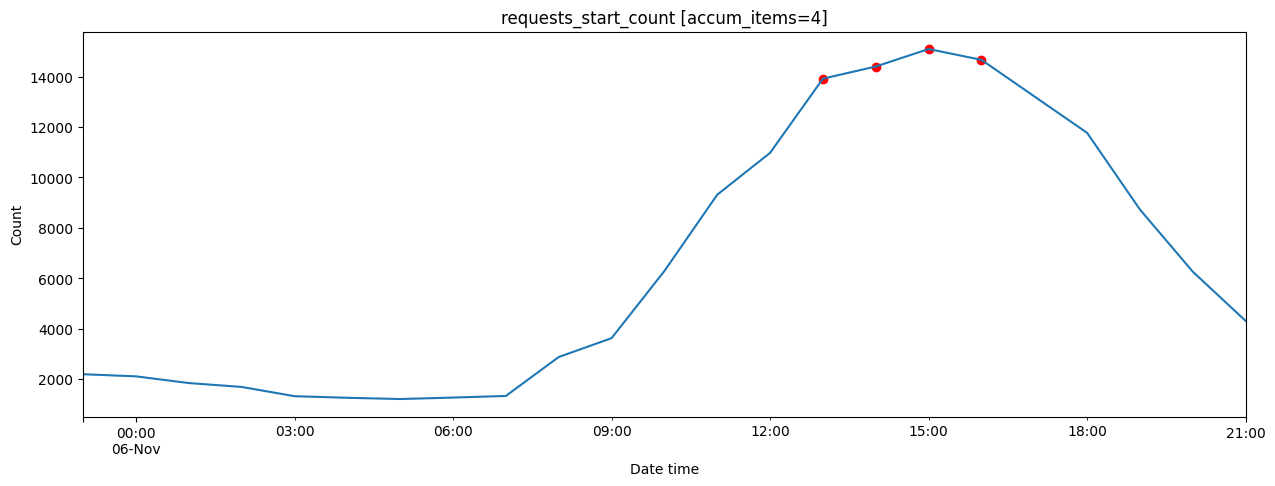

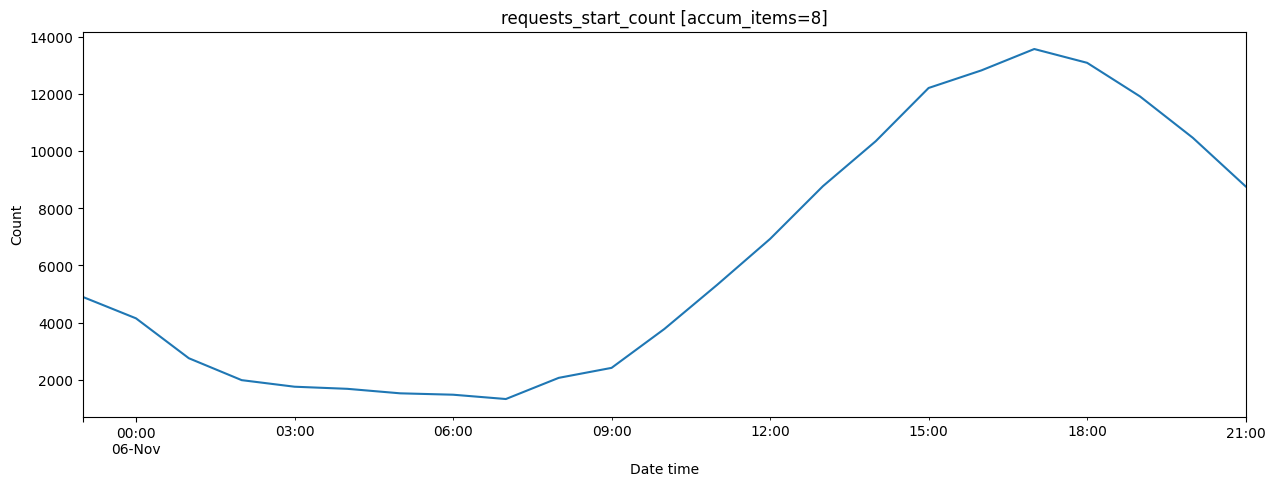

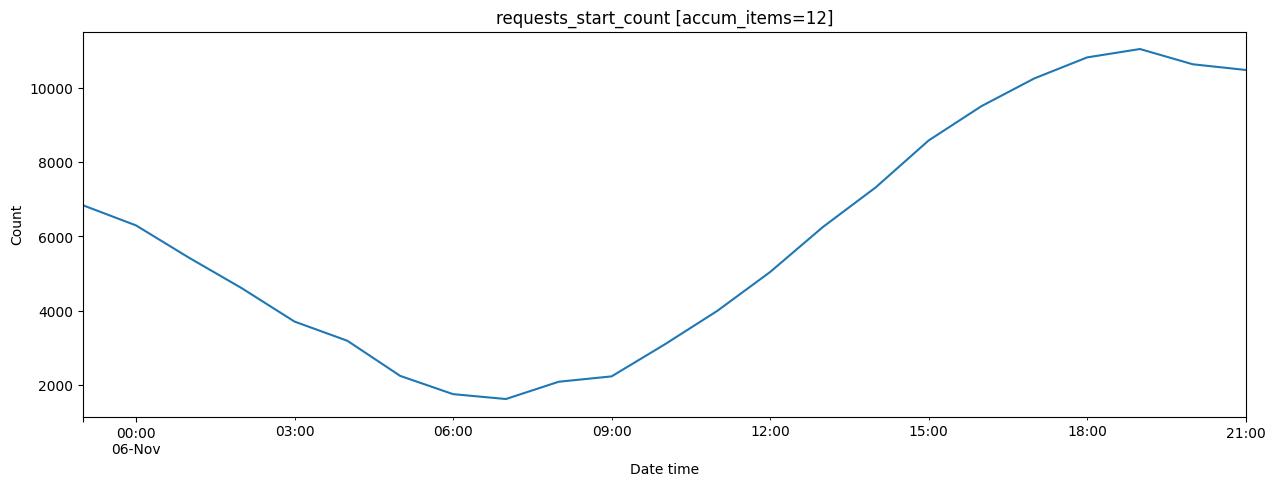

In [ ]:
import time
import matplotlib.pyplot as plt
from io import BytesIO
from datetime import timedelta, datetime

from models.anomaly_detect import anomaly_detect 
from models.mysqldb import Mysqldb
from models.metric import Metric
from config import config
from models.sysbf import SysBf

task_settings = {
    "data":{
        "project_id": 3,
        "metric_tag_id": 0,
        "metric_id": 2, 
        "granularity":"h1",
        "accum_items": [1, 4, 8, 12],
        # "dt_from": "2024-10-16",
        "dt_from": "",
        "last_items": 0
    },
    "anoms":{
        "direction": "both", 
        "max_anoms": 0.2, 
        "alpha": 0.01, 
        "piecewise_median_period_weeks": 2,
        "direction_reverce": True
    },
    "message_lvl":"all"
}

start_time = time.time()    
db = Mysqldb(config['db'])

for accum_items in task_settings['data']['accum_items']:
    
    mt = Metric.get_metric(db=db, id=task_settings['data']['metric_id'], 
                project_id=task_settings['data']['project_id'], 
                metric_tag_id=task_settings['data']['metric_tag_id'],          
                granularity=task_settings['data']['granularity']
                )
    
    print("metric_name: ", mt.info['metric_name'] + ";  dp: ", mt.info['metric_dp'])

    # dt_from = SysBf.tzdt_fr_str(task_settings['data']['dt_from'], "Europe/Moscow")
    # datetime_from = SysBf.tzdt((datetime.now() - timedelta(days=30)), "Europe/Moscow")
    # reliance = mt.get_data(accum_items=8, dt_from='', last_items=0) # 2024-06-01
    reliance = mt.get_data(accum_items=accum_items, 
                            dt_from=None, 
                            last_items=task_settings['data']['last_items'], 
                            tz_str="Europe/Moscow", tz_str_db="Europe/Moscow", drop_tz=True)
    
                                    
    res = reliance.squeeze()

    # direction options: pos | neg | both
    print('res items: ', len(res))

    anoms_settings = dict(task_settings['anoms']) 
    if len(res)>0:
        anom_dict = anomaly_detect(res, **anoms_settings) 
        anoms_pos = anom_dict['anoms_pos']
        anoms_neg = anom_dict['anoms_neg']

        datetime_from = SysBf.dt_to_tz(SysBf.tzdt(datetime.now(), "Europe/Moscow"), "notz") - timedelta(days=7)
        # datetime_from = datetime.now() - timedelta(days=7)
        res2 = SysBf.filter_series_by_datetime(res, datetime_from)

        fig, ax = plt.subplots(1, figsize=(15,5))
        res2.plot(ax=ax)
        if len(anoms_pos)>0:
            anoms_pos2 = SysBf.filter_series_by_datetime(anoms_pos, datetime_from)
            ax.scatter(anoms_pos2.index.values, anoms_pos2, color='green')
        if len(anoms_neg)>0:
            anoms_neg2 = SysBf.filter_series_by_datetime(anoms_neg, datetime_from)
            ax.scatter(anoms_neg2.index.values, anoms_neg2, color='red')
        ax.set_xlabel('Date time')
        ax.set_ylabel('Count')
        ax.set_title(mt.info['metric_name'] + ' [accum_items=' + str(accum_items) + ']')

        plot_file = BytesIO()
        fig.savefig(plot_file, format='png')
        plot_file.seek(0)

    else:
        print('No Data for metric!')    


print(round(time.time() - start_time, 4), 'sec')
